# Imports

In [1]:
%matplotlib inline
from collage import ImageCollage

# Construct potentials

$$c_{ij} = \max\limits_{k \in \{ 1, \dots, K\}} | I_i(k) - I_j(k) |$$

$$d(x_i, x_j) = |x_i \neq x_j|$$

## Experiments with synthetic data

In [2]:
synthetic_collage = ImageCollage('synthetic_simple', 3)

In [3]:
X = synthetic_collage.alpha_expansion()

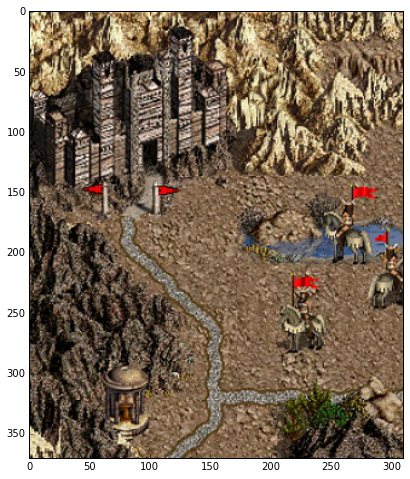

In [4]:
synthetic_collage.show_collage(X, save=True)

## Experiments with real data

In [5]:
real_collage = ImageCollage('real_simple', 3)

In [6]:
X = real_collage.alpha_expansion()

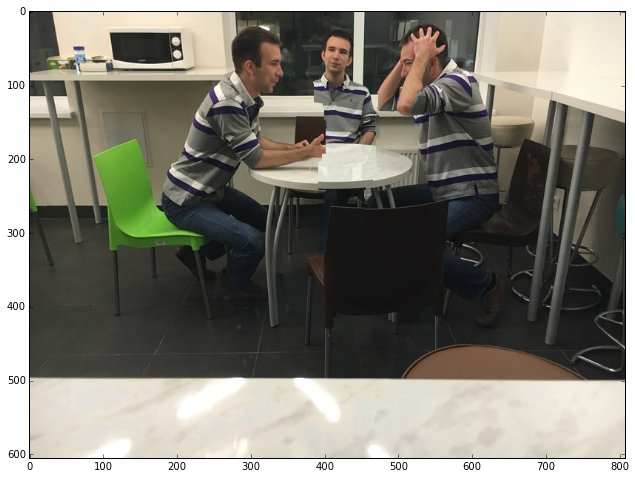

In [7]:
real_collage.show_collage(X, save=True)

# $\alpha \beta$-swap 

In [155]:
def alpha_beta_swap(phi_unary, c_pairwise, d, max_iter=100, tol=1e-3):
    '''
    Parameters:
        phi_unary -- matrix of unary potentials (N_vert x K)
        c_pairwise -- matrix of weights on the lattice (M_edg x 3),
            where each of 3 numbers are (from, to, c_{ij})
        d -- metric function        
    '''    
    # N_vert -- number of vertices
    # K -- number of classes
    N_vert, K = phi_unary.shape
    # M_edg -- number of edges
    M_edg = c_pairwise.shape[0]
    
    X = np.zeros(N_vert, dtype='int')
    
    E_old = np.inf
    alpha = 0
    for i_iter in xrange(max_iter):
        # randomly select alpha
        #alpha = np.random.randint(K)
        alpha = (alpha + 1) % K
        
        ################ Construct the graph #######################
        terminal_weights = np.zeros((N_vert, 2))
        edge_weights = np.zeros((M_edg, 4))
        
        terminal_weights[:, 0] = phi_unary[np.arange(N_vert), X] # y_i = 0 (X_i^{new} != \alpha)
        terminal_weights[X == alpha, 0] = inf # y_i cannot be zero where X_i^{old} = \alpha
        terminal_weights[:, 1] = phi_unary[:, alpha] # y_i = 1 (X_i^{new} = alpha)
        
        for j in xrange(M_edg):
            from_, to_, weight = c_pairwise[j]
            from_, to_ = int(from_), int(to_)
            phi_a = weight * d(X[from_], X[to_])
            phi_b = weight * d(X[from_], alpha)
            phi_c = weight * d(alpha, X[to_])
            phi_d = weight * d(alpha, alpha)
            
            phi_b_hat = (phi_b - phi_a + phi_c - phi_d)/2
            edge_weights[j] = (from_, to_, phi_b_hat, phi_b_hat)
            terminal_weights[from_][0] += phi_a
            terminal_weights[from_][1] += phi_d + (phi_c - phi_d - phi_b + phi_a)/2
            terminal_weights[to_][1] += (phi_b - phi_a - phi_c + phi_d)/2
        
        ################ Run graph cut #############################
        E, labels = graph_cut(terminal_weights, edge_weights)
        X[labels == 0] = alpha
        
        ################ Compute energy ############################
        if E_old - E < tol: break
        else: E_old = E
    
    return X